Importar bibliotecas

In [0]:
from __future__ import division, print_function
from torchvision import datasets, models, transforms
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import zipfile

Montar Google Drive

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Definir constantes

In [51]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

ZIP_FILE_PATH = './dataset.zip'
DATASET_PATH = './dataset'

INCEPTION = 'inception'
VGG19 = 'vgg-19'
MODEL = VGG19 # Define o tipo de modelo a ser usado.
IMG_SIZE = {
  INCEPTION: 299,
  VGG19: 224,
}[MODEL]
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

BATCH_SIZE = 4
NUM_WORKERS = 4

TRAIN = 'train'
VAL = 'val'
TEST = 'test'
PHASES = {
  TRAIN: 'train',
  VAL: 'val',
  TEST: 'test',
}

print(DEVICE)

cuda:0


Limpar diretorio do dataset


In [0]:
shutil.rmtree(DATASET_PATH)

Extrair dataset

In [0]:
zip_file = zipfile.ZipFile(ZIP_FILE_PATH)
zip_file.extractall()
zip_file.close()

Carregar dataset

In [54]:
# Augmentacao de dados para treinamento,
# apenas normalizacao para validacao e teste.
data_transforms = {
  TRAIN: transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
  ]),
  VAL: transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
  ]),
  TEST: transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
  ]),
}
data_sets = {
  phase: datasets.ImageFolder(
    os.path.join(DATASET_PATH, PHASES[phase]),
    data_transforms[phase],
  ) for phase in PHASES
}
data_loaders = {
  phase: torch.utils.data.DataLoader(
    data_sets[phase],
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
  ) for phase in PHASES
}
data_sizes = {
  phase: len(data_sets[phase]) for phase in PHASES
}
class_names = data_sets[TRAIN].classes

print(data_sets)
print(data_loaders)
print(data_sizes)
print(class_names)

{'train': Dataset ImageFolder
    Number of datapoints: 8984
    Root location: ./dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-15, 15), resample=False, expand=False)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 1492
    Root location: ./dataset/val
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'test': Dataset ImageFolder
    Number of datapoints: 1492
    Root location: ./dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
        

Helper functions

In [0]:
# Exibe uma imagem a partir de um Tensor.
def imshow(data):
  mean = np.array(NORMALIZE_MEAN)
  std = np.array(NORMALIZE_STD)
  image = data.numpy().transpose((1, 2, 0))
  image = std * image + mean
  image = np.clip(image, 0, 1)
  plt.imshow(image)

In [0]:
# Treina o modelo e retorna o modelo treinado.
def train_model(model_type, model, optimizer, criterion, num_epochs = 25):
  start_time = time.time()

  num_epochs_without_improvement = 0

  best_acc = 0.0
  best_model = copy.deepcopy(model.state_dict())
  torch.save(best_model, 'model.pth')

  for epoch in range(num_epochs):
    print('Epoch {}/{} ...'.format(epoch + 1, num_epochs))

    for phase in PHASES:
      if phase == TRAIN:
        model.train()
      elif phase == VAL:
        model.eval()
      else:
        continue

      running_loss = 0.0
      running_corrects = 0

      for data, labels in data_loaders[phase]:
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == TRAIN):
          outputs = model(data)
          if phase == TRAIN and model_type == INCEPTION:
            outputs = outputs.logits
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == TRAIN:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / data_sizes[phase]
      epoch_acc = running_corrects.double() / data_sizes[phase]

      print('{} => Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == VAL:
        if epoch_acc > best_acc:
          num_epochs_without_improvement = 0
          best_acc = epoch_acc
          best_model = copy.deepcopy(model.state_dict())
          torch.save(best_model, 'model.pth')
        else:
          num_epochs_without_improvement += 1
    
    if num_epochs_without_improvement == 50:
      print('Exiting early...')
      break

  elapsed_time = time.time() - start_time
  print('Took {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))
  print('Best Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model)

  return model

In [0]:
# Visualiza algumas predicoes do modelo.
def visualize_model(model, num_images = 6):
  was_training = model.training

  model.eval()

  fig = plt.figure()
  images_so_far = 0

  with torch.no_grad():
    for i, (data, labels) in enumerate(data_loaders[TEST]):
      data = data.to(DEVICE)
      labels = labels.to(DEVICE)

      outputs = model(data)
      _, preds = torch.max(outputs, 1)

      for j in range(data.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('Predicted: {}'.format(class_names[preds[j]]))
        imshow(data.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode = was_training)
          return

    model.train(mode = was_training)

In [0]:
# Testa o modelo.
def test_model(model, criterion):
  was_training = model.training

  model.eval()

  running_loss = 0.0
  running_corrects = 0

  with torch.no_grad():
    for data, labels in data_loaders[TEST]:
      data = data.to(DEVICE)
      labels = labels.to(DEVICE)

      outputs = model(data)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      running_loss += loss.item() * data.size(0)
      running_corrects += torch.sum(preds == labels.data)

  loss = running_loss / data_sizes[TEST]
  acc = running_corrects.double() / data_sizes[TEST]

  print('Loss: {:4f}, Acc: {:4f}'.format(loss, acc))

  model.train(mode = was_training)

Exibir amostra do dataset

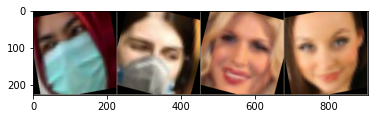

In [59]:
data, labels = next(iter(data_loaders[TRAIN]))
grid = torchvision.utils.make_grid(data)
imshow(grid)

Definir modelo

In [60]:
if MODEL == INCEPTION:
  model = models.inception_v3(pretrained = True, progress = True)

  print(model.fc)

  for param in model.parameters():
    param.requires_grad = False
  
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, len(class_names))
  model = model.to(DEVICE)
  optimizer = optim.SGD(model.fc.parameters(), lr = 0.001, momentum = 0.9)
elif MODEL == VGG19:
  model = models.vgg19(pretrained = True, progress = True)

  print(model.classifier[6])

  for param in model.parameters():
    param.requires_grad = False
  
  num_features = model.classifier[6].in_features
  model.classifier[6] = nn.Linear(num_features, len(class_names))
  model = model.to(DEVICE)
  optimizer = optim.SGD(model.classifier[6].parameters(), lr = 0.001, momentum = 0.9)
else:
  print('ERRO: Nenhum tipo de modelo definido!')

criterion = nn.CrossEntropyLoss()

print(model)

Linear(in_features=4096, out_features=1000, bias=True)
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): C

Treinar modelo

In [39]:
model = train_model(MODEL, model, optimizer, criterion)

Epoch 1/25 ...
train => Loss: 0.2408, Acc: 0.9290
val => Loss: 0.0465, Acc: 0.9873
Epoch 2/25 ...
train => Loss: 0.2668, Acc: 0.9349
val => Loss: 0.0503, Acc: 0.9846
Epoch 3/25 ...
train => Loss: 0.2629, Acc: 0.9396
val => Loss: 0.0587, Acc: 0.9859
Epoch 4/25 ...
train => Loss: 0.2539, Acc: 0.9426
val => Loss: 0.0474, Acc: 0.9873
Epoch 5/25 ...
train => Loss: 0.2492, Acc: 0.9435
val => Loss: 0.0945, Acc: 0.9779
Epoch 6/25 ...
train => Loss: 0.2480, Acc: 0.9487
val => Loss: 0.0662, Acc: 0.9819
Epoch 7/25 ...
train => Loss: 0.2377, Acc: 0.9498
val => Loss: 0.1097, Acc: 0.9786
Epoch 8/25 ...
train => Loss: 0.2525, Acc: 0.9477
val => Loss: 0.0424, Acc: 0.9913
Epoch 9/25 ...
train => Loss: 0.2601, Acc: 0.9478
val => Loss: 0.0372, Acc: 0.9926
Epoch 10/25 ...
train => Loss: 0.2743, Acc: 0.9437
val => Loss: 0.0907, Acc: 0.9772
Epoch 11/25 ...
train => Loss: 0.2360, Acc: 0.9533
val => Loss: 0.0644, Acc: 0.9859
Epoch 12/25 ...
train => Loss: 0.2275, Acc: 0.9515
val => Loss: 0.0505, Acc: 0.9866
E

Visualizar modelo

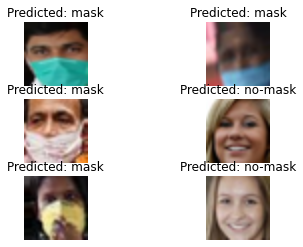

In [47]:
visualize_model(model)

Testar modelo

In [48]:
model.load_state_dict(torch.load('model.pth'))
test_model(model, criterion)

Loss: 0.101816, Acc: 0.980563


Salvar modelo para CPU

In [0]:
model = model.cpu()
torch.save(model.state_dict(), 'model-cpu.pth')

Salvar no Google Drive

In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/model-vgg.pth')